## Phase 3 (Data Preparation)

Datan esikäsittelyvaiheessa on tarkoitus käsitellä ja valmistella data sellaiseen kuntoon, että sitä voidaan käyttää helposti mallinnusvaiheessa ilman merkittäviä lisämuokkauksia.   
   
Vaiheessa keskitytyään esimerkiksi tietojen: 
- Puhdistamiseen 
- Muokkaamiseen 
- Valitsemiseen   

- Lopuksi data skaalataan ja/tai normalisoidaan. 

Vaiheessa on paljon tekemistä, mutta sen onnistuminen on tärkeä myös koko projektin onnistumisen kannalta. Datan esikäsittelyvaiheeseen saatetaan joutua palaamaan takaisin vielä myöhemmässä vaiheessa projektia. 


### Tästä lähtee datan esikäsittelyvaiheen toteutus

- Ladataan esikäsittelemätön data

In [1]:
#import kaggle
#import zipfile
import pandas as pd
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

file_path = r"C:\Lataukset\used_cars\used_cars_data.csv"

# Get the total number of rows
total_rows = sum(1 for _ in open(file_path, encoding='ISO-8859-1'))  # Count rows for progress

# Create an empty dataframe to accumulate chunks
dataframe = pd.DataFrame()

# Read in chunks and display a progress bar
chunk_size = 10000  # You can adjust the chunk size based on your memory capacity
for chunk in tqdm(pd.read_csv(file_path, chunksize=chunk_size), total=total_rows // chunk_size, desc="Loading CSV"):
    dataframe = pd.concat([dataframe, chunk])

print("Data loaded successfully.")

Loading CSV: 301it [03:30,  1.43it/s]                         

Data loaded successfully.


Sarakkeiden poistoja:

- Poistetaan sarakkeita, joilla ei katsota olevan arvoa lopputuloksen kannalta
- Poistetaan sarakkeet, joissa liikaa NaN-arvoja
- Poistetaan toinen sellaisista sarakkeista, jotka sisältävät saman tiedon

In [2]:

# Näillä sarakkeilla ei katsota olevan arvoa lopputuloksen kannalta
dataframe.drop(columns=[
    'vin',
    'description',
    'listing_id',
    'main_picture_url',
    'bed',
    'bed_height',
    'bed_length',
    'cabin',
    'combine_fuel_economy',
    'is_certified',
    'is_cpo',
    'is_oemcpo',
    'latitude',
    'longitude',
    'vehicle_damage_category',
    'engine_type',
    'engine_cylinders'
    ],axis=1,inplace=True)

'''
- `trim_name` ja `trimId` periaatteessa sisältävät samaa tietoa, joten `trimId`-kolumnin voi pudottaa ja `encodaa` `trim_name`.
- `wheel_system` ja `wheel_system_display` sama asia, joten voi valita jomman kumman (esim., `wheel_system_display`) ja `encodaa` tarvittaessa.
- Pudotetaan siis trimId ja wheel_system pois
'''

dataframe.drop(columns=[
    'trimId', 
    'wheel_system'
    ],axis=1, inplace=True)

dataframe.info()
dataframe.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000040 entries, 0 to 3000039
Data columns (total 47 columns):
 #   Column                Dtype  
---  ------                -----  
 0   back_legroom          object 
 1   body_type             object 
 2   city                  object 
 3   city_fuel_economy     float64
 4   daysonmarket          int64  
 5   dealer_zip            object 
 6   engine_displacement   float64
 7   exterior_color        object 
 8   fleet                 object 
 9   frame_damaged         object 
 10  franchise_dealer      bool   
 11  franchise_make        object 
 12  front_legroom         object 
 13  fuel_tank_volume      object 
 14  fuel_type             object 
 15  has_accidents         object 
 16  height                object 
 17  highway_fuel_economy  float64
 18  horsepower            float64
 19  interior_color        object 
 20  isCab                 object 
 21  is_new                bool   
 22  length                object 
 23  listed_

,back_legroom,body_type,city,city_fuel_economy,daysonmarket,dealer_zip,engine_displacement,exterior_color,fleet,frame_damaged,...,sp_name,theft_title,torque,transmission,transmission_display,trim_name,wheel_system_display,wheelbase,width,year
0,35.1 in,SUV / Crossover,Bayamon,NaN,522,960,1300.0,Solar Yellow,NaN,NaN,...,Flagship Chrysler,NaN,"200 lb-ft @ 1,750 RPM",A,9-Speed Automatic Overdrive,Latitude FWD,Front-Wheel Drive,101.2 in,79.6 in,2019
1,38.1 in,SUV / Crossover,San Juan,NaN,207,922,2000.0,Narvik Black,NaN,NaN,...,Land Rover San Juan,NaN,"269 lb-ft @ 1,400 RPM",A,9-Speed Automatic Overdrive,S AWD,All-Wheel Drive,107.9 in,85.6 in,2020
2,35.4 in,Sedan,Guaynabo,17.0,1233,969,2500.0,NaN,False,False,...,FIAT de San Juan,False,"290 lb-ft @ 4,000 RPM",M,6-Speed Manual,Base,All-Wheel Drive,104.3 in,78.9 in,2016
3,37.6 in,SUV / Crossover,San Juan,NaN,196,922,3000.0,Eiger Gray,NaN,NaN,...,Land Rover San Juan,NaN,"332 lb-ft @ 3,500 RPM",A,8-Speed Automatic Overdrive,V6 HSE AWD,All-Wheel Drive,115 in,87.4 in,2020
4,38.1 in,SUV / Crossover,San Juan,NaN,137,922,2000.0,Narvik Black,NaN,NaN,...,Land Rover San Juan,NaN,"269 lb-ft @ 1,400 RPM",A,9-Speed Automatic Overdrive,S AWD,All-Wheel Drive,107.9 in,85.6 in,2020


In [3]:

# ilmeisesti object tyypiset setit voi one-hot encodaa käyttämällä pd.get_dummies() funktiota, ilman että tarvitsee muutta str

Data-tyyppien muutokset:

- Muutetaan objekti-tyyppiset sarakkeet numeeriseksi ja booleaniksi kun mahdollista
- Päivämäärän käsittely

In [4]:
# Preprosessataan nämä objekti-kolumnit numeriseksi:

# back_legroom numeriseksi
dataframe['back_legroom'] = dataframe['back_legroom'].astype(str).apply(lambda x: x.split()[0])
dataframe['back_legroom'] = pd.to_numeric(dataframe['back_legroom'], errors='coerce')

# dealer_zip numeriseksi
dataframe['dealer_zip'] = pd.to_numeric(dataframe['dealer_zip'], errors='coerce')
#print(dataframe['dealer_zip'].dtype) - float64

# front_legroom numeriseksi
dataframe['front_legroom'] = dataframe['front_legroom'].astype(str).apply(lambda x: x.split()[0])
dataframe['front_legroom'] = pd.to_numeric(dataframe['front_legroom'], errors='coerce')

# fuel_tank_volume numeriseksi
dataframe['fuel_tank_volume'] = dataframe['fuel_tank_volume'].astype(str).apply(lambda x: x.split()[0])
dataframe['fuel_tank_volume'] = pd.to_numeric(dataframe['fuel_tank_volume'], errors='coerce')

# height numeriseksi
dataframe['height'] = dataframe['height'].astype(str).apply(lambda x: x.split()[0])
dataframe['height'] = pd.to_numeric(dataframe['height'], errors='coerce')

# lenght numeriseksi
dataframe['length'] = dataframe['length'].astype(str).apply(lambda x: x.split()[0])
dataframe['length'] = pd.to_numeric(dataframe['length'], errors='coerce')

# maximum_seating numeriseksi
dataframe['maximum_seating'] = dataframe['maximum_seating'].astype(str).apply(lambda x: x.split()[0])
dataframe['maximum_seating'] = pd.to_numeric(dataframe['maximum_seating'], errors='coerce')

# wheelbase numeriseksi
dataframe['wheelbase'] = dataframe['wheelbase'].astype(str).apply(lambda x: x.split()[0])
dataframe['wheelbase'] = pd.to_numeric(dataframe['wheelbase'], errors='coerce')

# width numeriseksi
dataframe['width'] = dataframe['width'].astype(str).apply(lambda x: x.split()[0])
dataframe['width'] = pd.to_numeric(dataframe['width'], errors='coerce')




In [5]:
# Preprosessataan nämä objekti-kolumnit booleaniksi:

# fleet boolenaiksi
dataframe['fleet'] = dataframe['fleet'].map({'True': True, 'False': False})
dataframe['fleet'] = dataframe['fleet'].fillna(False)

# frame_damaged boolenaiksi
dataframe['frame_damaged'] = dataframe['frame_damaged'].map({'True': True, 'False': False})
dataframe['frame_damaged'] = dataframe['frame_damaged'].fillna(False)

# has_accidents boolenaiksi
dataframe['has_accidents'] = dataframe['has_accidents'].map({'True': True, 'False': False})
dataframe['has_accidents'] = dataframe['has_accidents'].fillna(False)

# isCab booleaniksi
dataframe['isCab'] = dataframe['isCab'].map({'True': True, 'False': False})
dataframe['isCab'] = dataframe['isCab'].fillna(False)

# salvage booleaniksi
dataframe['salvage'] = dataframe['salvage'].map({'True': True, 'False': False})
dataframe['salvage'] = dataframe['salvage'].fillna(False) 

# theft_title booleaniksi
dataframe['theft_title'] = dataframe['theft_title'].map({'True': True, 'False': False})
dataframe['theft_title'] = dataframe['theft_title'].fillna(False)

In [6]:
# Päivämäärän käsittely ja luodaan uusia sarakkeita

# muutetaan date datetimeen
dataframe['listed_date'] = pd.to_datetime(dataframe['listed_date'], errors='coerce')

# lisätietoa vuosista päivistä ja kuukausista
dataframe['listed_year'] = dataframe['listed_date'].dt.year
dataframe['listed_month'] = dataframe['listed_date'].dt.month
dataframe['listed_dayofweek'] = dataframe['listed_date'].dt.dayofweek

In [7]:
# Jaetaan power -sarake hevosvoimiksi (power_hp) ja kierrosluvuiksi (power_rmp)

dataframe['power_hp'] = dataframe['power'].apply(lambda x: x.split()[0] if isinstance(x, str) else None)
dataframe['power_rpm'] = dataframe['power'].apply(lambda x: x.split()[3] if isinstance(x, str) and len(x.split()) >= 4 else None)

dataframe['power_hp'] = pd.to_numeric(dataframe['power_hp'], errors='coerce')
dataframe['power_rpm'] = pd.to_numeric(dataframe['power_rpm'], errors='coerce')

# Poistetaan alkuperäinen power -sarake
dataframe.drop(columns=['power'], inplace=True)


In [8]:
# Jaetaan torque samalla tavallu kun power
dataframe['torque_value'] = dataframe['torque'].apply(lambda x: x.split()[0] if isinstance(x, str) else None)
dataframe['torque_rpm'] = dataframe['torque'].apply(lambda x: x.split()[3] if isinstance(x, str) and len(x.split()) >= 4 else None)

dataframe['torque_value'] = pd.to_numeric(dataframe['torque_value'], errors='coerce')
dataframe['torque_rpm'] = pd.to_numeric(dataframe['torque_rpm'], errors='coerce')

# Poistetaan alkuperäinen torque -sarake
dataframe.drop(columns=['torque'], inplace=True)



In [9]:

# sp_name on hankala, koska niin monta unique arvoa voi joko dropata tai ehkä ryhmitellä top 10 myyjää
# dataframe.drop(columns=['sp_name'], inplace=True)



Välitsekkaus sarakkeiden tyyppimuunnoksista.

In [10]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000040 entries, 0 to 3000039
Data columns (total 52 columns):
 #   Column                Dtype         
---  ------                -----         
 0   back_legroom          float64       
 1   body_type             object        
 2   city                  object        
 3   city_fuel_economy     float64       
 4   daysonmarket          int64         
 5   dealer_zip            float64       
 6   engine_displacement   float64       
 7   exterior_color        object        
 8   fleet                 bool          
 9   frame_damaged         bool          
 10  franchise_dealer      bool          
 11  franchise_make        object        
 12  front_legroom         float64       
 13  fuel_tank_volume      float64       
 14  fuel_type             object        
 15  has_accidents         bool          
 16  height                float64       
 17  highway_fuel_economy  float64       
 18  horsepower            float64       
 19  

In [11]:
print("Statistical Summary of Numerical Columns:")
dataframe = dataframe.query('year >= 1990')
round(dataframe.select_dtypes(exclude = ['object']).describe() , 2)

Statistical Summary of Numerical Columns:


,back_legroom,city_fuel_economy,daysonmarket,dealer_zip,engine_displacement,front_legroom,fuel_tank_volume,height,highway_fuel_economy,horsepower,...,wheelbase,width,year,listed_year,listed_month,listed_dayofweek,power_hp,power_rpm,torque_value,torque_rpm
count,2756932.00,2508178.00,2994755.00,2994546.00,2826599.00,2823851.00,2839133.00,2839317.00,2508178.00,2826599.00,...,2839346.00,2839325.00,2994755.00,2994755.00,2994755.00,2994755.00,2517557.00,3927.00,2481197.00,54805.00
mean,37.96,22.70,75.80,50682.97,2968.03,42.20,18.61,65.88,29.48,248.02,...,115.33,78.39,2017.81,2019.92,7.29,3.44,251.42,631.28,265.23,201.00
min,0.00,7.00,0.00,922.00,700.00,0.00,1.90,43.50,10.00,55.00,...,73.50,42.50,1990.00,2010.00,1.00,0.00,55.00,516.00,58.00,200.00
25%,36.00,18.00,14.00,29691.00,2000.00,41.00,14.70,58.10,25.00,175.00,...,106.30,72.40,2017.00,2020.00,7.00,2.00,175.00,600.00,176.00,200.00
50%,38.20,21.00,35.00,48161.00,2500.00,42.00,17.70,66.10,29.00,244.00,...,111.20,77.30,2020.00,2020.00,8.00,3.00,250.00,650.00,258.00,200.00
75%,39.90,26.00,82.00,76691.00,3600.00,43.00,21.10,70.20,33.00,300.00,...,118.90,83.10,2020.00,2020.00,8.00,5.00,308.00,650.00,320.00,200.00
max,59.80,127.00,3599.00,99518.00,8400.00,67.00,64.00,117.60,127.00,1001.00,...,204.50,109.00,2021.00,2020.00,12.00,6.00,949.00,650.00,944.00,400.00
std,3.18,8.81,108.15,27374.39,1348.71,1.51,5.46,7.56,7.77,90.47,...,14.51,7.67,3.65,0.29,2.11,1.66,90.17,27.58,119.63,9.31


Katsotaan mitä arvoja jäljelle jääneet "object" -tyyppiset sarakkeet pitävät sisällään.

Nämä pitää esikäsitellä mallin ymmärtämään muotoon, esim. encoding.

Osassa sarakkeita liikaa uniikkeja arvoja encoodauksen kannalta.

In [12]:
cat_cols = dataframe.select_dtypes(include=['object']).columns
for col in cat_cols:
    unique_values = dataframe[col].unique()
    print(f"Total unique values: {len(unique_values)}")
    print("Top 10 most common values:")
    print(dataframe[col].value_counts().head(10))  # Show top 10 most common values
    print("\n")

# joissain näissä paha tehdä encoding unique arvojen määrän takia

Total unique values: 10
Top 10 most common values:
body_type
SUV / Crossover    1416077
Sedan               741213
Pickup Truck        474086
Hatchback            88194
Minivan              79788
Coupe                69537
Van                  47150
Wagon                40464
Convertible          25233
Name: count, dtype: int64


Total unique values: 4686
Top 10 most common values:
city
Houston         43742
San Antonio     24940
Columbus        18314
Miami           18028
Jacksonville    16826
Las Vegas       16365
Tampa           15325
Phoenix         14785
Dallas          14624
Orlando         14487
Name: count, dtype: int64


Total unique values: 28203
Top 10 most common values:
exterior_color
Black                     161928
White                     126098
Summit White               96432
Silver                     78741
Gray                       77461
Oxford White               59089
Blue                       50822
Bright White Clearcoat     43467
Red                        42

In [13]:
cat_cols = dataframe.select_dtypes(include=['object']).columns

# Calculate null counts for each categorical column
null_counts = dataframe[cat_cols].isnull().sum()
print(null_counts)

body_type                13013
city                         0
exterior_color           49430
franchise_make          567958
fuel_type                78937
interior_color          382838
listing_color                0
major_options           195471
make_name                    0
model_name                   0
sp_name                      0
transmission             63526
transmission_display     63526
trim_name               113358
wheel_system_display    142758
dtype: int64


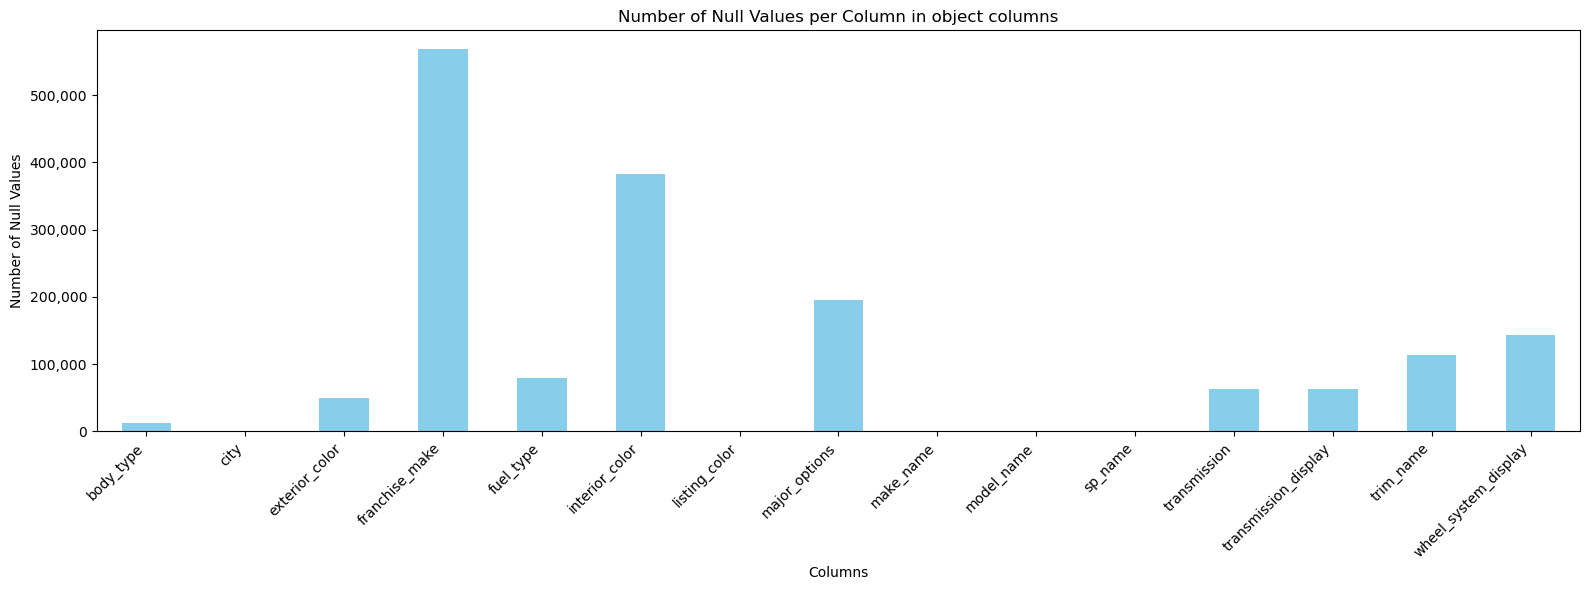

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 6))
null_counts.plot.bar(color='skyblue')
plt.title('Number of Null Values per Column in object columns')
plt.xlabel('Columns')
plt.ylabel('Number of Null Values')
plt.xticks(rotation=45, ha='right')

plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x):,}'))
plt.tight_layout()
plt.show()

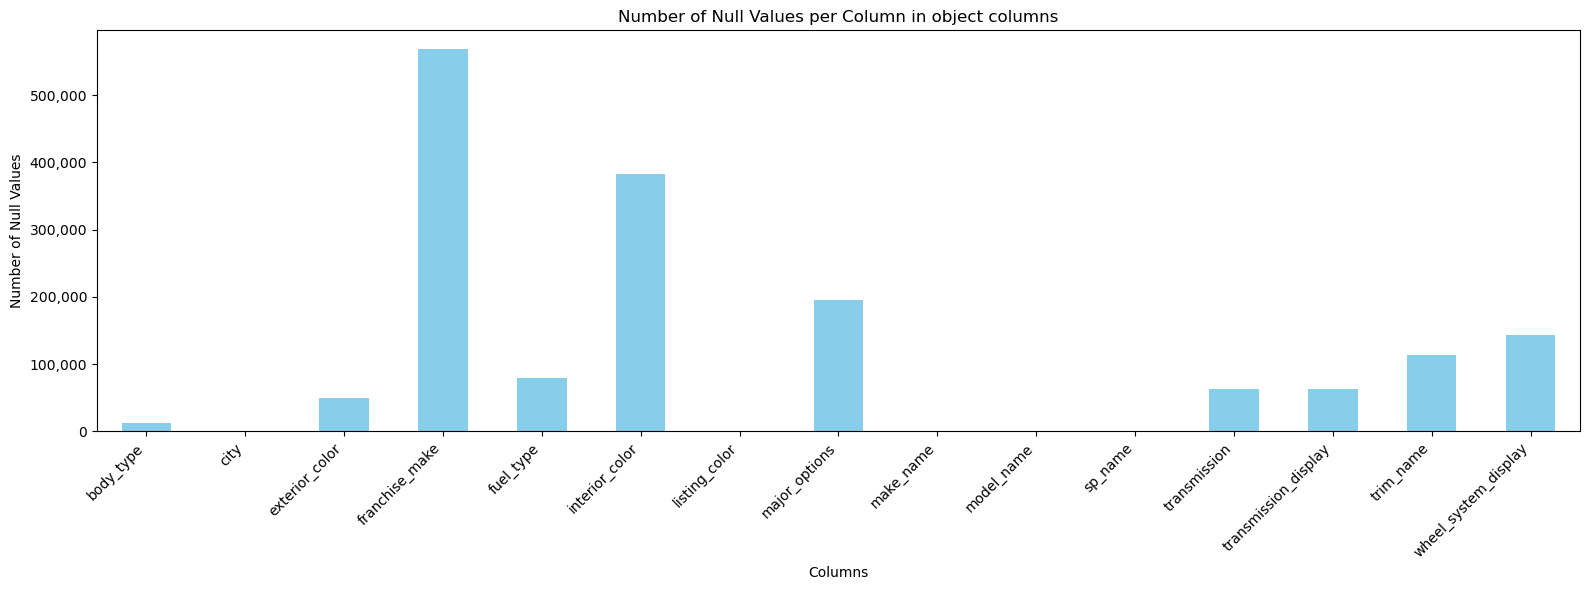

In [15]:
# Tämä kuva kun osa sarakkeiden tyypeistä oli muutettu/ poistettu, sis vaan 1 milj riviä, ei koko aineisto
# Vain vertauksen vuoksi tuohon edelliseen
import pandas as pd
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 6))
null_counts.plot.bar(color='skyblue')
plt.title('Number of Null Values per Column in object columns')
plt.xlabel('Columns')
plt.ylabel('Number of Null Values')
plt.xticks(rotation=45, ha='right')

plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x):,}'))
plt.tight_layout()
plt.show()

In [16]:
columns_to_check = ['front_legroom', 'fuel_tank_volume', 'height', 'maximum_seating', 
                    'power_hp', 'power_rpm', 'torque_rpm', 'wheelbase', 'width', 'back_legroom']

for col in columns_to_check:
    count = (dataframe[col] == '--').sum()
    print(f"Column '{col}' has {count} rows with '--'")
    

Column 'front_legroom' has 0 rows with '--'
Column 'fuel_tank_volume' has 0 rows with '--'
Column 'height' has 0 rows with '--'
Column 'maximum_seating' has 0 rows with '--'
Column 'power_hp' has 0 rows with '--'
Column 'power_rpm' has 0 rows with '--'
Column 'torque_rpm' has 0 rows with '--'
Column 'wheelbase' has 0 rows with '--'
Column 'width' has 0 rows with '--'
Column 'back_legroom' has 0 rows with '--'


In [17]:
a =('''
Muutettu objekteista numeeriseksi dataa. Joitakin booliksi meneviä jäänyt objektiksi NaN arvojen takia. Dropattu turhia sarakkeita.
Työstetty date column -> muutama uusi. Jotkut objektit vaativat työstöä encodingina varten. 
''')
print(a)


Muutettu objekteista numeeriseksi dataa. Joitakin booliksi meneviä jäänyt objektiksi NaN arvojen takia. Dropattu turhia sarakkeita.
Työstetty date column -> muutama uusi. Jotkut objektit vaativat työstöä encodingina varten. 



In [18]:
sara = ('''
Jouduin rullaamaan koodin nrows=1000000 rivillä kun ei oikein mennyt läpi koko datalla, eli voi alusta tuon poistaa ken kykenee datan ajaa koko datalla :D
Siistitty koodia ehkä selkeämpiin kokonaisuuksiin (mitä tehty missäkin vaiheessa), pudotettu sarakkeita ja muokattu tyyppejä, Valtteri oli kyllä jo hyvin alustanutkin tyyppimuunnoksia
One-hot-encoodaus varmaan tuonne missä muitakin sarakkeiden tyyppimuunnoksia.. voi olla kyllä muuallakin jos katsoo parhaaksi
''')
print(sara)


Jouduin rullaamaan koodin nrows=1000000 rivillä kun ei oikein mennyt läpi koko datalla, eli voi alusta tuon poistaa ken kykenee datan ajaa koko datalla :D
Siistitty koodia ehkä selkeämpiin kokonaisuuksiin (mitä tehty missäkin vaiheessa), pudotettu sarakkeita ja muokattu tyyppejä, Valtteri oli kyllä jo hyvin alustanutkin tyyppimuunnoksia
One-hot-encoodaus varmaan tuonne missä muitakin sarakkeiden tyyppimuunnoksia.. voi olla kyllä muuallakin jos katsoo parhaaksi



NaN-arvojen käsittelyä ja lisää sarakkeiden poistoa:

- Katsotaan sarakkeittain NaN-arvojen määriä suuruus järjestyksessä
- Yhdistetään 'make_name' ja 'franchise_make' -sarakkeet, sillä suuri osa arvoista yhtenäisiä
- Poistetaan sarakkeet, jotka pitävät sisällään suurimman määrän NaN-arvoja
- Lopuksi poistetaan kaikki rivit, jotka pitävät sisällään NaN-arvoja

In [19]:
nan_counts = pd.DataFrame({'Column': dataframe.columns, 'NaN_Count': dataframe.isna().sum()}).reset_index(drop=True)
nan_counts_sorted = nan_counts.sort_values(by='NaN_Count', ascending=False).reset_index(drop=True)

print(f"Rivien määrä: {len(dataframe)}")
print(f"Sarakkeiden määrä: {len(dataframe.columns)}")
print("tyhjien arvojen määrä per sarake")
print(nan_counts_sorted)

Rivien määrä: 2994755
Sarakkeiden määrä: 52
tyhjien arvojen määrä per sarake
                  Column  NaN_Count
0              power_rpm    2990828
1             torque_rpm    2939950
2            owner_count    1513070
3         franchise_make     567958
4           torque_value     513558
5      city_fuel_economy     486577
6   highway_fuel_economy     486577
7               power_hp     477198
8         interior_color     382838
9           back_legroom     237823
10         major_options     195471
11         front_legroom     170904
12   engine_displacement     168156
13            horsepower     168156
14      fuel_tank_volume     155622
15       maximum_seating     155477
16                height     155438
17                length     155431
18                 width     155430
19             wheelbase     155409
20               mileage     143204
21  wheel_system_display     142758
22             trim_name     113358
23             fuel_type      78937
24  transmission_displa

In [20]:
# Filter rows with non-NaN values in 'power_rpm'
filtered_df = dataframe[dataframe['power_rpm'].notna()]

len(filtered_df)

3927

In [21]:
# Replace NaN in franchise_make with values from make_name
dataframe['franchise_make'] = dataframe['franchise_make'].fillna(dataframe['make_name'])

# Find rows where franchise_make is different from make_name
mismatch_count = (dataframe['franchise_make'] != dataframe['make_name']).sum()

print(f"Number of rows with different franchise_make and make_name: {mismatch_count}")

Number of rows with different franchise_make and make_name: 467787


In [22]:
#tarkistetaan nyt franchise make

nan_counts = pd.DataFrame({'Column': dataframe.columns, 'NaN_Count': dataframe.isna().sum()}).reset_index(drop=True)
nan_counts_sorted = nan_counts.sort_values(by='NaN_Count', ascending=False).reset_index(drop=True)

print(f"Rivien määrä: {len(dataframe)}")
print(f"Sarakkeiden määrä: {len(dataframe.columns)}")
print("tyhjien arvojen määrä per sarake")
print(nan_counts_sorted)

Rivien määrä: 2994755
Sarakkeiden määrä: 52
tyhjien arvojen määrä per sarake
                  Column  NaN_Count
0              power_rpm    2990828
1             torque_rpm    2939950
2            owner_count    1513070
3           torque_value     513558
4   highway_fuel_economy     486577
5      city_fuel_economy     486577
6               power_hp     477198
7         interior_color     382838
8           back_legroom     237823
9          major_options     195471
10         front_legroom     170904
11   engine_displacement     168156
12            horsepower     168156
13      fuel_tank_volume     155622
14       maximum_seating     155477
15                height     155438
16                length     155431
17                 width     155430
18             wheelbase     155409
19               mileage     143204
20  wheel_system_display     142758
21             trim_name     113358
22             fuel_type      78937
23  transmission_display      63526
24          transmissio

In [23]:
#poistetaan eniten tyhjiä arvoja sisältävät sarakkeet
dataframe.drop(columns=['power_rpm', 'torque_rpm', 'owner_count'], inplace=True)

nan_counts = pd.DataFrame({'Column': dataframe.columns, 'NaN_Count': dataframe.isna().sum()}).reset_index(drop=True)
nan_counts_sorted = nan_counts.sort_values(by='NaN_Count', ascending=False).reset_index(drop=True)

print(f"Rivien määrä: {len(dataframe)}")
print(f"Sarakkeiden määrä: {len(dataframe.columns)}")
print("tyhjien arvojen määrä per sarake")
print(nan_counts_sorted.head(10))

Rivien määrä: 2994755
Sarakkeiden määrä: 49
tyhjien arvojen määrä per sarake
                 Column  NaN_Count
0          torque_value     513558
1  highway_fuel_economy     486577
2     city_fuel_economy     486577
3              power_hp     477198
4        interior_color     382838
5          back_legroom     237823
6         major_options     195471
7         front_legroom     170904
8   engine_displacement     168156
9            horsepower     168156


In [24]:
#Testataan paljonko jää rivejä jos poistetaan kaikki NaN

cleaned_df = dataframe.dropna()

print(cleaned_df.shape)

(1686514, 49)


In [25]:
#Testataan jos poistetaan seuraavat 3 suurinta NaN arvollista saraketta, sekä power_hp joka on jo horsepower -sarakkeessa.

#poistetaan eniten tyhjiä arvoja sisältävät sarakkeet
dataframe.drop(columns=['torque_value', 'highway_fuel_economy', 'city_fuel_economy', 'power_hp'], inplace=True)


nan_counts = pd.DataFrame({'Column': dataframe.columns, 'NaN_Count': dataframe.isna().sum()}).reset_index(drop=True)
nan_counts_sorted = nan_counts.sort_values(by='NaN_Count', ascending=False).reset_index(drop=True)

print(f"Rivien määrä: {len(dataframe)}")
print(f"Sarakkeiden määrä: {len(dataframe.columns)}")
print("tyhjien arvojen määrä per sarake")
print(nan_counts_sorted.head(10))

Rivien määrä: 2994755
Sarakkeiden määrä: 45
tyhjien arvojen määrä per sarake
                Column  NaN_Count
0       interior_color     382838
1         back_legroom     237823
2        major_options     195471
3        front_legroom     170904
4  engine_displacement     168156
5           horsepower     168156
6     fuel_tank_volume     155622
7      maximum_seating     155477
8               height     155438
9               length     155431


In [26]:
#Testataan paljonko jää rivejä jos poistetaan kaikki NaN
#sp_name:ssa myyjän lisäämiä asioita esim. GT, Sport, kaupunki missä myynnissä
#trim_name trimmattu nimi
#transmission_display tarkemmat arvot vaihteille, monta erilaista tekstiä, jätetään transmission -sarake kuvaamaan automati, manual, ctv ja dual clutchia.
dataframe.drop(columns=['exterior_color', 'interior_color', 'sp_name', 'trim_name', 'transmission_display'], inplace=True)


cleaned_df2 = dataframe.dropna()

print(cleaned_df2.shape)
print(cleaned_df2.columns)
pd.set_option('display.max_columns', None)

#len(cleaned_df2['sp_name'].unique())
cleaned_df2.head(5)


(2374936, 40)
Index(['back_legroom', 'body_type', 'city', 'daysonmarket', 'dealer_zip',
       'engine_displacement', 'fleet', 'frame_damaged', 'franchise_dealer',
       'franchise_make', 'front_legroom', 'fuel_tank_volume', 'fuel_type',
       'has_accidents', 'height', 'horsepower', 'isCab', 'is_new', 'length',
       'listed_date', 'listing_color', 'major_options', 'make_name',
       'maximum_seating', 'mileage', 'model_name', 'price', 'salvage',
       'savings_amount', 'seller_rating', 'sp_id', 'theft_title',
       'transmission', 'wheel_system_display', 'wheelbase', 'width', 'year',
       'listed_year', 'listed_month', 'listed_dayofweek'],
      dtype='object')


,back_legroom,body_type,city,daysonmarket,dealer_zip,engine_displacement,fleet,frame_damaged,franchise_dealer,franchise_make,front_legroom,fuel_tank_volume,fuel_type,has_accidents,height,horsepower,isCab,is_new,length,listed_date,listing_color,major_options,make_name,maximum_seating,mileage,model_name,price,salvage,savings_amount,seller_rating,sp_id,theft_title,transmission,wheel_system_display,wheelbase,width,year,listed_year,listed_month,listed_dayofweek
0,35.1,SUV / Crossover,Bayamon,522,960.0,1300.0,False,False,True,Jeep,41.2,12.7,Gasoline,False,66.5,177.0,False,True,166.6,2019-04-06,YELLOW,['Quick Order Package'],Jeep,5.0,7.0,Renegade,23141.0,False,0,2.8,370599.0,False,A,Front-Wheel Drive,101.2,79.6,2019,2019,4,5
1,38.1,SUV / Crossover,San Juan,207,922.0,2000.0,False,False,True,Land Rover,39.1,17.7,Gasoline,False,68.0,246.0,False,True,181.0,2020-02-15,BLACK,['Adaptive Cruise Control'],Land Rover,7.0,8.0,Discovery Sport,46500.0,False,0,3.0,389227.0,False,A,All-Wheel Drive,107.9,85.6,2020,2020,2,5
4,38.1,SUV / Crossover,San Juan,137,922.0,2000.0,False,False,True,Land Rover,39.1,17.7,Gasoline,False,68.0,246.0,False,True,181.0,2020-04-25,BLACK,['Adaptive Cruise Control'],Land Rover,7.0,7.0,Discovery Sport,48880.0,False,0,3.0,389227.0,False,A,All-Wheel Drive,107.9,85.6,2020,2020,4,5
5,37.1,SUV / Crossover,San Juan,242,922.0,2000.0,False,False,True,Land Rover,40.2,16.6,Gasoline,False,66.3,247.0,False,True,188.9,2020-01-11,UNKNOWN,"['Leather Seats', 'Sunroof/Moonroof', 'Navigat...",Land Rover,5.0,12.0,Range Rover Velar,66903.0,False,0,3.0,389227.0,False,A,All-Wheel Drive,113.1,84.4,2020,2020,1,5
6,35.1,Sedan,Bayamon,447,960.0,2500.0,False,False,True,Jeep,42.3,13.2,Gasoline,False,56.9,186.0,False,True,183.5,2019-06-20,SILVER,"['Alloy Wheels', 'Bluetooth', 'Backup Camera']",Mazda,5.0,14.0,MAZDA3,23695.0,False,0,2.8,370599.0,False,A,Front-Wheel Drive,107.3,70.7,2019,2019,6,3


## Datan oneHot enkoodaus ja numeraalinen loppukäsittely

In [27]:
cleaned_df2['fuel_type'].unique()

array(['Gasoline', 'Diesel', 'Biodiesel', 'Flex Fuel Vehicle', 'Hybrid',
       'Compressed Natural Gas', 'Electric', 'Propane'], dtype=object)

In [28]:
cleaned_df2['wheel_system_display'].unique()

cleaned_df2 = pd.get_dummies(cleaned_df2, columns=['wheel_system_display'], prefix='wheel')
cleaned_df2.head(2)

,back_legroom,body_type,city,daysonmarket,dealer_zip,engine_displacement,fleet,frame_damaged,franchise_dealer,franchise_make,front_legroom,fuel_tank_volume,fuel_type,has_accidents,height,horsepower,isCab,is_new,length,listed_date,listing_color,major_options,make_name,maximum_seating,mileage,model_name,price,salvage,savings_amount,seller_rating,sp_id,theft_title,transmission,wheelbase,width,year,listed_year,listed_month,listed_dayofweek,wheel_4X2,wheel_All-Wheel Drive,wheel_Four-Wheel Drive,wheel_Front-Wheel Drive,wheel_Rear-Wheel Drive
0,35.1,SUV / Crossover,Bayamon,522,960.0,1300.0,False,False,True,Jeep,41.2,12.7,Gasoline,False,66.5,177.0,False,True,166.6,2019-04-06,YELLOW,['Quick Order Package'],Jeep,5.0,7.0,Renegade,23141.0,False,0,2.8,370599.0,False,A,101.2,79.6,2019,2019,4,5,False,False,False,True,False
1,38.1,SUV / Crossover,San Juan,207,922.0,2000.0,False,False,True,Land Rover,39.1,17.7,Gasoline,False,68.0,246.0,False,True,181.0,2020-02-15,BLACK,['Adaptive Cruise Control'],Land Rover,7.0,8.0,Discovery Sport,46500.0,False,0,3.0,389227.0,False,A,107.9,85.6,2020,2020,2,5,False,True,False,False,False


In [29]:
cleaned_df2['transmission'].unique()

cleaned_df2 = pd.get_dummies(cleaned_df2, columns=['transmission'], prefix='transmission')
cleaned_df2.head(2)

,back_legroom,body_type,city,daysonmarket,dealer_zip,engine_displacement,fleet,frame_damaged,franchise_dealer,franchise_make,front_legroom,fuel_tank_volume,fuel_type,has_accidents,height,horsepower,isCab,is_new,length,listed_date,listing_color,major_options,make_name,maximum_seating,mileage,model_name,price,salvage,savings_amount,seller_rating,sp_id,theft_title,wheelbase,width,year,listed_year,listed_month,listed_dayofweek,wheel_4X2,wheel_All-Wheel Drive,wheel_Four-Wheel Drive,wheel_Front-Wheel Drive,wheel_Rear-Wheel Drive,transmission_A,transmission_CVT,transmission_Dual Clutch,transmission_M
0,35.1,SUV / Crossover,Bayamon,522,960.0,1300.0,False,False,True,Jeep,41.2,12.7,Gasoline,False,66.5,177.0,False,True,166.6,2019-04-06,YELLOW,['Quick Order Package'],Jeep,5.0,7.0,Renegade,23141.0,False,0,2.8,370599.0,False,101.2,79.6,2019,2019,4,5,False,False,False,True,False,True,False,False,False
1,38.1,SUV / Crossover,San Juan,207,922.0,2000.0,False,False,True,Land Rover,39.1,17.7,Gasoline,False,68.0,246.0,False,True,181.0,2020-02-15,BLACK,['Adaptive Cruise Control'],Land Rover,7.0,8.0,Discovery Sport,46500.0,False,0,3.0,389227.0,False,107.9,85.6,2020,2020,2,5,False,True,False,False,False,True,False,False,False


In [30]:
cleaned_df2['body_type'].unique()

cleaned_df2 = pd.get_dummies(cleaned_df2, columns=['body_type'], prefix='body_type')
cleaned_df2.head(2)

,back_legroom,city,daysonmarket,dealer_zip,engine_displacement,fleet,frame_damaged,franchise_dealer,franchise_make,front_legroom,fuel_tank_volume,fuel_type,has_accidents,height,horsepower,isCab,is_new,length,listed_date,listing_color,major_options,make_name,maximum_seating,mileage,model_name,price,salvage,savings_amount,seller_rating,sp_id,theft_title,wheelbase,width,year,listed_year,listed_month,listed_dayofweek,wheel_4X2,wheel_All-Wheel Drive,wheel_Four-Wheel Drive,wheel_Front-Wheel Drive,wheel_Rear-Wheel Drive,transmission_A,transmission_CVT,transmission_Dual Clutch,transmission_M,body_type_Convertible,body_type_Coupe,body_type_Hatchback,body_type_Minivan,body_type_Pickup Truck,body_type_SUV / Crossover,body_type_Sedan,body_type_Van,body_type_Wagon
0,35.1,Bayamon,522,960.0,1300.0,False,False,True,Jeep,41.2,12.7,Gasoline,False,66.5,177.0,False,True,166.6,2019-04-06,YELLOW,['Quick Order Package'],Jeep,5.0,7.0,Renegade,23141.0,False,0,2.8,370599.0,False,101.2,79.6,2019,2019,4,5,False,False,False,True,False,True,False,False,False,False,False,False,False,False,True,False,False,False
1,38.1,San Juan,207,922.0,2000.0,False,False,True,Land Rover,39.1,17.7,Gasoline,False,68.0,246.0,False,True,181.0,2020-02-15,BLACK,['Adaptive Cruise Control'],Land Rover,7.0,8.0,Discovery Sport,46500.0,False,0,3.0,389227.0,False,107.9,85.6,2020,2020,2,5,False,True,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False


In [31]:
cleaned_df2['listing_color'].unique()

# Define the color mapping for the listing_color column
color_mapping = {
    'BLACK': 'black, unknown',
    'UNKNOWN': 'black, unknown',
    'YELLOW': 'yellow, orange, gold',
    'ORANGE': 'yellow, orange, gold',
    'GOLD': 'yellow, orange, gold',
    'WHITE': 'white, gray, silver',
    'GRAY': 'white, gray, silver',
    'SILVER': 'white, gray, silver',
    'RED': 'red, blue, green, brown',
    'BLUE': 'red, blue, green, brown',
    'GREEN': 'red, blue, green, brown',
    'BROWN': 'red, blue, green, brown',
    'PURPLE': 'purple, pink, teal',
    'PINK': 'purple, pink, teal',
    'TEAL': 'purple, pink, teal'
}

# Create the new column based on the color mapping
cleaned_df2['combined_listing_color'] = cleaned_df2['listing_color'].map(color_mapping)

# Check the result
print(cleaned_df2[['listing_color', 'combined_listing_color']].head())

cleaned_df2 = pd.get_dummies(cleaned_df2, columns=['combined_listing_color'], prefix='listing_color')
cleaned_df2.head(2)

  listing_color combined_listing_color
0        YELLOW   yellow, orange, gold
1         BLACK         black, unknown
4         BLACK         black, unknown
5       UNKNOWN         black, unknown
6        SILVER    white, gray, silver


,back_legroom,city,daysonmarket,dealer_zip,engine_displacement,fleet,frame_damaged,franchise_dealer,franchise_make,front_legroom,fuel_tank_volume,fuel_type,has_accidents,height,horsepower,isCab,is_new,length,listed_date,listing_color,major_options,make_name,maximum_seating,mileage,model_name,price,salvage,savings_amount,seller_rating,sp_id,theft_title,wheelbase,width,year,listed_year,listed_month,listed_dayofweek,wheel_4X2,wheel_All-Wheel Drive,wheel_Four-Wheel Drive,wheel_Front-Wheel Drive,wheel_Rear-Wheel Drive,transmission_A,transmission_CVT,transmission_Dual Clutch,transmission_M,body_type_Convertible,body_type_Coupe,body_type_Hatchback,body_type_Minivan,body_type_Pickup Truck,body_type_SUV / Crossover,body_type_Sedan,body_type_Van,body_type_Wagon,"listing_color_black, unknown","listing_color_purple, pink, teal","listing_color_red, blue, green, brown","listing_color_white, gray, silver","listing_color_yellow, orange, gold"
0,35.1,Bayamon,522,960.0,1300.0,False,False,True,Jeep,41.2,12.7,Gasoline,False,66.5,177.0,False,True,166.6,2019-04-06,YELLOW,['Quick Order Package'],Jeep,5.0,7.0,Renegade,23141.0,False,0,2.8,370599.0,False,101.2,79.6,2019,2019,4,5,False,False,False,True,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True
1,38.1,San Juan,207,922.0,2000.0,False,False,True,Land Rover,39.1,17.7,Gasoline,False,68.0,246.0,False,True,181.0,2020-02-15,BLACK,['Adaptive Cruise Control'],Land Rover,7.0,8.0,Discovery Sport,46500.0,False,0,3.0,389227.0,False,107.9,85.6,2020,2020,2,5,False,True,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False


In [32]:
print(len(cleaned_df2['franchise_make'].unique()))
print(len(cleaned_df2['make_name'].unique()))
list1 = cleaned_df2['franchise_make'].unique()
list2 = cleaned_df2['make_name'].unique()

unique_to_list1 = set(list1) - set(list2)
print(unique_to_list1)

60
53
{'smart', 'McLaren', 'Lamborghini', 'Lotus', 'SRT', 'Shelby', 'Ferrari'}


Poistetaan siis vielä tuo make_name sillä sisältää vähemmän tietoja kuin franchise_make

# Datan skaalaaminen ja malliin vietävät sarakkeet

In [33]:
from sklearn.preprocessing import LabelEncoder

fuel_type_encoder = LabelEncoder()
make_encoder = LabelEncoder()
city_encoder = LabelEncoder()
model_encoder = LabelEncoder()

#enkoodataan, niin monta saraketta
cleaned_df2['fuel_type_encoded'] = city_encoder.fit_transform(cleaned_df2['fuel_type'])
cleaned_df2['make_encoded'] = make_encoder.fit_transform(cleaned_df2['franchise_make'])
cleaned_df2['city_encoded'] = city_encoder.fit_transform(cleaned_df2['city'])
cleaned_df2['model_encoded'] = model_encoder.fit_transform(cleaned_df2['model_name'])

In [34]:
# sarakkeet jota jätetään pois mallintamisen vaiheessa, tekstipohjaiset visuaalisaation jälkeen poistettava

pudotettavat = ['listing_color', 'make_name']
enkoodatut = ['fuel_type', 'franchise_make', 'city', 'model_name'] #jatkon kannalta talteen

cleaned_df2.drop(columns=pudotettavat, inplace=True)

final_df = cleaned_df2
final_df.head(2)

,back_legroom,city,daysonmarket,dealer_zip,engine_displacement,fleet,frame_damaged,franchise_dealer,franchise_make,front_legroom,fuel_tank_volume,fuel_type,has_accidents,height,horsepower,isCab,is_new,length,listed_date,major_options,maximum_seating,mileage,model_name,price,salvage,savings_amount,seller_rating,sp_id,theft_title,wheelbase,width,year,listed_year,listed_month,listed_dayofweek,wheel_4X2,wheel_All-Wheel Drive,wheel_Four-Wheel Drive,wheel_Front-Wheel Drive,wheel_Rear-Wheel Drive,transmission_A,transmission_CVT,transmission_Dual Clutch,transmission_M,body_type_Convertible,body_type_Coupe,body_type_Hatchback,body_type_Minivan,body_type_Pickup Truck,body_type_SUV / Crossover,body_type_Sedan,body_type_Van,body_type_Wagon,"listing_color_black, unknown","listing_color_purple, pink, teal","listing_color_red, blue, green, brown","listing_color_white, gray, silver","listing_color_yellow, orange, gold",fuel_type_encoded,make_encoded,city_encoded,model_encoded
0,35.1,Bayamon,522,960.0,1300.0,False,False,True,Jeep,41.2,12.7,Gasoline,False,66.5,177.0,False,True,166.6,2019-04-06,['Quick Order Package'],5.0,7.0,Renegade,23141.0,False,0,2.8,370599.0,False,101.2,79.6,2019,2019,4,5,False,False,False,True,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,5,26,231,648
1,38.1,San Juan,207,922.0,2000.0,False,False,True,Land Rover,39.1,17.7,Gasoline,False,68.0,246.0,False,True,181.0,2020-02-15,['Adaptive Cruise Control'],7.0,8.0,Discovery Sport,46500.0,False,0,3.0,389227.0,False,107.9,85.6,2020,2020,2,5,False,True,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,5,30,3471,230


### Datan skaalaaminen

In [35]:
#tähän skaalaukset



21.11.2024 klo 22.32: Mielestäni jää enää siis:

1. major_options <- sarakkeen käsittely (en ehtinyt yhtään paneutua tai miettiä mitenkä tämän kanssa) Oli kuitenkin yhtenä vaatimusmäärittelyn/asiakkaan kysymyksenä, miten lisäominaisuudet vaikuttavat haluttavuuteen

2. mahd. mietintä tehdäänkö "new features" eli tarviiko jotain lisätä? <- tätä joudetaa miettimään kun päästää eteenpäin
3. visualisaatio <- #Pekkatekeesunnuntaina ja saa muutkin tehdä ´:)
4. skaalaus
5. luokkamuuttujat?

## Phase 3 guide (Data Preparation)

* Select data
* Clean the data
* Integrate data
* Format data
* Construct the data

## Additional questions:

* Handling of missing values
* Handling of outliers
* Remove "unnecessary features"
* Add "new features"
* Also visualize after preprocessing
* Perform data scaling
* Classification class variable?

Important: The result data from this phase should have good quality for the next step, i.e. modeling.